# <font style="font-family:roboto;color:#455e6c"> Validation of interatomic potentials </font>  

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c"> <b> DPG Tutorial: Automated Workflows and Machine Learning for Materials Science Simulations </b> </font> </br>
<font style="font-family:roboto;color:#455e6c"> 16 March 2024 </font>
</div>

To ensure that our fitted ACE potentials provide reliable predictions, it is crucial to validate them against reference data from DFT calculations or experiments. In this notebook, we will use previously fitted ACE potential(s) to compute key properties—namely, energies, equilibrium volumes, and bulk moduli—for various phases. 

This validation step corresponds to Level 2 validation from the schematic, and is essential to confirm that the potentials capture the underlying physics accurately and can be confidently used for further simulations and analysis.


<img src="img/validation_schematic.png" alt="Validation schematic" width="700"/>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyiron_nodes.atomistic.properties.murnaghan import * 

### <font style="font-family:roboto;color:#455e6c"> ACE and GRACE Calculators </font>  

For simulations involving ACE and GRACE potentials, having ASE-compatible calculators is essential. In our workflow, these calculators are implemented as Pyiron nodes.

In [2]:
from pyiron_nodes.atomistic.mlips.calculator.ace import Ace

# provide the file path to the ACE potential
potential_path = "potentials/Better_potential.yace"
potential_path = "potentials/Ca_Mg_linear_potential.yace"


ace = Ace(potential_path)

Several pre-fitted GRACE foundation models are available for use. You can choose from the following options:

- `MP_GRACE_1L_r6_4Nov2024`
- `MP_GRACE_1L_r6_07Nov2024`
- `MP_GRACE_2L_r6_11Nov2024`
- `MP_GRACE_2L_r5_4Nov2024`
- `MP_GRACE_2L_r5_07Nov2024`
- `GRACE_2L_OAM_28Jan25`
- `GRACE-1L-OAM_2Feb25`

For further details about the GRACE foundation models, please refer to the [Grace documentation](https://gracemaker.readthedocs.io/en/latest/gracemaker/foundation/).

Note that you only need to provide the model string as an argument—the associated potential files will be downloaded at runtime.


In [3]:
from pyiron_nodes.atomistic.mlips.calculator.grace import Grace


grace = Grace('GRACE-FS-OMAT')

In [4]:
# set one of ace or grace calcs as the default calculator for further calculations

# calc = grace_calc
calc = ace

### <font style="font-family:roboto;color:#455e6c"> Basic workflow for validation of energy-volume curves </font>  

In the current notebook, we will utilize the defined models and predict the energies, volumes, and bulk moduli of certain phases. We accomplish this through a series of workflow nodes that perform the following tasks:

1. **Build the Structure:**  
   Using a minimal input (such as an element string, e.g. `"Ca"`), we generate a bulk atomic structure using the `Bulk` node from `pyiron_nodes`. This node creates the structure based on common crystallographic data.

2. **Structure Optimization:**  
   The generated structure is optimized using the chosen calculator. In this step, the atomic positions and cell parameters are relaxed (using algorithms such as BFGS) until the forces are below a specified threshold. This optimization is critical to ensure that the following energy-volume calculations are accurate.

3. **Energy–Volume (EV) Curve Calculation:**  
   Once optimized, the workflow computes an EV curve by scaling the unit cell around the equilibrium volume. For each scaled structure, the potential energy is calculated.

4. **Plotting:**  
   Optionally, the EV curve and the fitted EOS are plotted. This allows us to visually assess the smoothness of the potential energy landscape predicted by the models.

5. **Fitting the Birch–Murnaghan Equation of State:**  
   The computed EV curve is fitted to the Birch–Murnaghan equation of state (EOS). This fitting yields important physical quantities:
   - **E0:** Equilibrium energy
   - **V0:** Equilibrium volume
   - **B0:** Bulk modulus  
   These parameters are essential for comparing the ACE potential predictions with DFT or experimental reference data.




#### <font style="font-family:roboto;color:#455e6c"> Build the structure </font>  

Use an in-built node `from pyiron_nodes.atomistic.structure.build import Bulk` to generate atomic structures. For single-element phases, the node automatically generates the ground-state structure for the given element with a rough guess for the lattice parameter.

Execute `Bulk?` for more details

In [5]:
from pyiron_nodes.atomistic.structure.build import Bulk 
# Bulk?

In [6]:
bulk_struc = Bulk("Ca", cubic=True)
bulk_struc = bulk_struc.pull()
bulk_struc

Ca: [0. 0. 0.]
Ca: [0.   2.79 2.79]
Ca: [2.79 0.   2.79]
Ca: [2.79 2.79 0.  ]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([5.58, 5.58, 5.58])

#### <font style="font-family:roboto;color:#455e6c"> Structure optimization </font> 

The generated structure may not be in equilibirum. Before proceeding further, it is important that the structure is optimized.

We use a predefined `OptimizeStructure` function to relax both the atomic positions and cell vectors.

In [8]:
opt_struc = Relax(mode="full", calculator=calc, opt=GenericOptimizerSettings(), structure=bulk_struc)
opt_struc = opt_struc.pull()
opt_struc

Ca: [1.83580287e-17 1.86289959e-17 1.86967377e-17]
Ca: [1.86799074e-17 2.60032929e+00 2.60032929e+00]
Ca: [2.60032929e+00 1.85444238e-17 2.60032929e+00]
Ca: [2.60032929e+00 2.60032929e+00 1.84766820e-17]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([[5.2006585821292, 5.091143560866124e-20, 5.091143560866124e-20], [5.091143560866124e-20, 5.2006585821292, 5.091143560866124e-20], [5.091143560866124e-20, 5.091143560866124e-20, 5.2006585821292]])

#### <font style="font-family:roboto;color:#455e6c"> Energy-Volume curve calculation </font>  

With the optimized structure (denoted as `opt_struc`) in hand, we proceed to calculate the energy-volume (EV) curves. These curves provide essential information about the structure, including the equilibrium energy, equilibrium volume (and the corresponding lattice parameter), as well as the bulk modulus. Such properties can be directly compared to DFT results or experimental data.

We utilize a predefined node, `CalculateEVCurve`, to generate a DataFrame containing the atomic volumes and their corresponding energies. This node offers several parameters that allow you to fine-tune the volume range and the number of calculation points, ensuring a detailed and accurate EV curve.


In [10]:
ev_curve_df = CalculateEVCurve(
                                structure=opt_struc, 
                                calculator=calc, 
                                vol_range = 0.1,
                                num_of_points = 11,
                            )

ev_curve_df = ev_curve_df.pull()
ev_curve_df

,volume,energy,ase_atoms
0,31.648822,-2.016179,"[Atom('Ca', [1.772448184926276e-17, 1.79860978..."
1,32.310198,-2.032320,"[Atom('Ca', [1.7847096464766425e-17, 1.8110522..."
2,32.980724,-2.044571,"[Atom('Ca', [1.796971108027009e-17, 1.82349466..."
3,33.660464,-2.053165,"[Atom('Ca', [1.8092325695773755e-17, 1.8359371..."
4,34.349480,-2.058329,"[Atom('Ca', [1.8214940311277422e-17, 1.8483795..."
5,35.047834,-2.060272,"[Atom('Ca', [1.8337554926781088e-17, 1.8608219..."
6,35.755591,-2.059198,"[Atom('Ca', [1.846016954228475e-17, 1.87326443..."
7,36.472812,-2.055295,"[Atom('Ca', [1.8582784157788415e-17, 1.8857068..."
8,37.199561,-2.048742,"[Atom('Ca', [1.870539877329208e-17, 1.89814932..."
9,37.935901,-2.039710,"[Atom('Ca', [1.8828013388795746e-17, 1.9105917..."


#### <font style="font-family:roboto;color:#455e6c"> Plotting the EV curve </font>  

The node`PlotEVCurve` allows us to plot the dataframe obtained in the previous step. Visualizing the EV curves provides an indication of the smoothness of the predicted potential energy surface.

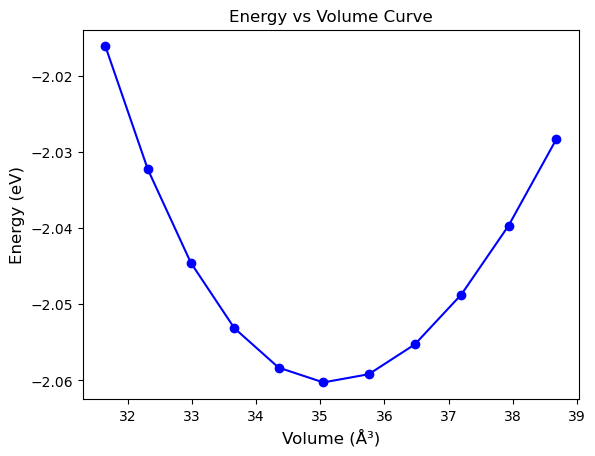

In [11]:
ev_plot = PlotEVCurve(ev_curve_df = ev_curve_df)
ev_plot.pull();

#### <font style="font-family:roboto;color:#455e6c"> Fitting the Birch–Murnaghan Equation of State </font>  


The Birch-Murnaghan EOS is given by,  

$E(V) = E_0 + \frac{9V_0 B_0}{16} \Bigg\{ \Bigg[\frac{V_0}{V}^{\frac{2}{3}} - 1\Bigg]^3 B_0^\prime + \Bigg[ \frac{V_0}{V}^{\frac{2}{3}} - 1\Bigg]^2 \Bigg[ \frac{V_0}{V}^{\frac{2}{3}} \Bigg] \Bigg\}$.


By fitting the EV data to this equation, we can extract the key parameters: the equilibrium energy $E_0$, equilibrium volume $V_0$, bulk modulus $B_0$, and its pressure derivative $B_0'$. This is achieved by invoking the node `FitBirchMurnaghanEOS` and supplying the EV data as input.

In [12]:
fit = FitBirchMurnaghanEOS(ev_curve_df)
E0, V0, B0 = fit.pull()

print(f"E0={E0}, V0={V0}, B0={B0}")

E0=-2.060297089869817, V0=35.14224771856395, B0=33.93771966201445


### <font style="font-family:roboto;color:#455e6c"> Combine everything in a workflow </font>  

The individual functions described above can be seamlessly integrated into a single workflow using the `pyiron_workflow.Workflow` object. All the steps—from structure generation and optimization to EV curve calculation and EOS fitting—are encapsulated within the `make_murnaghan_workflow` node.

To create the complete workflow, simply provide the element name (which is used to build the structure) and the potential path (which selects the appropriate calculator). This unified workflow streamlines the validation process, making it straightforward to assess the quality of your potentials.


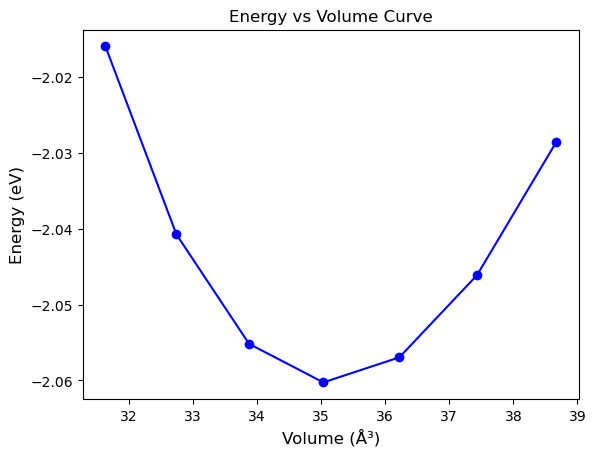

Equilibrium Energy (E0): -2.060296858624972
Equilibrium Volume (V0): 35.14225706358915
Bulk Modulus (B0): 33.936594847386644


In [13]:
wf = make_murnaghan_workflow("Ca_workflow1",
                             element_str="Ca",
                             potential_path = "potentials/Ca_Mg_linear_potential.yace",
                             delete_existing_savefiles=True)

# run the workflow
wf.run()

# print the output values
print("Equilibrium Energy (E0):", wf.outputs["fit_eos__E0"].value)
print("Equilibrium Volume (V0):", wf.outputs["fit_eos__V0"].value)
print("Bulk Modulus (B0):", wf.outputs["fit_eos__B0_GPa"].value)

### <font style="font-family:roboto;color:#455e6c"> GUI </font>  

A powerful feature of `pyiron_workflow` is its interactive GUI, which lets you visualize the entire workflow. Through this interface, you can easily inspect the individual nodes and their connections, as well as modify them—either one node at a time or adjust how they interact with each other.


In [14]:
from pyironflow import PyironFlow

pf = PyironFlow([wf])

In [15]:
pf.gui

### <font style="font-family:roboto;color:#455e6c"> Generate Multiple Workflows to Compare Different Potentials over Multiple Structures </font>  

Now that we have established how to create a workflow for a given structure and potential, we can extend this approach to explore a variety of cases. In this section, we generate multiple workflows by iterating over three different structures—Ca-fcc, Mg-hcp, and a CaMg phase (sourced from the [Materials Project](https://next-gen.materialsproject.org/materials/mp-1039120/))—and testing them against various potentials.

Once these workflows are created, we can run them and then iterate over the results to produce comparison plots. This comprehensive analysis enables us to assess the performance of different potentials across multiple phases.


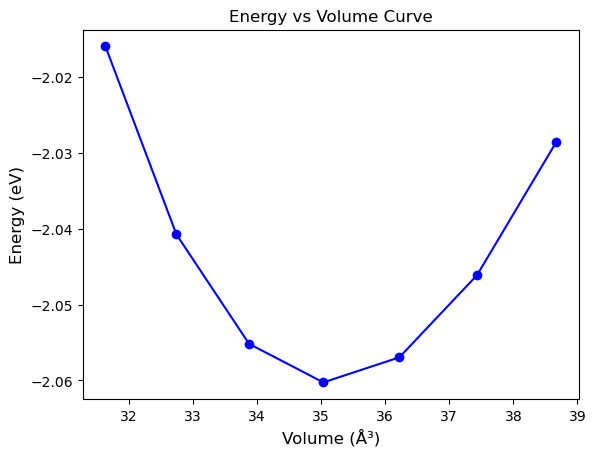

Using cached GRACE model from /home/poul/.cache/grace/GRACE-1L-OAM
Model license: Academic Software License


I0000 00:00:1741989362.574937     741 service.cc:145] XLA service 0x560a3d77d6b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741989362.575002     741 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1741989366.388261     741 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


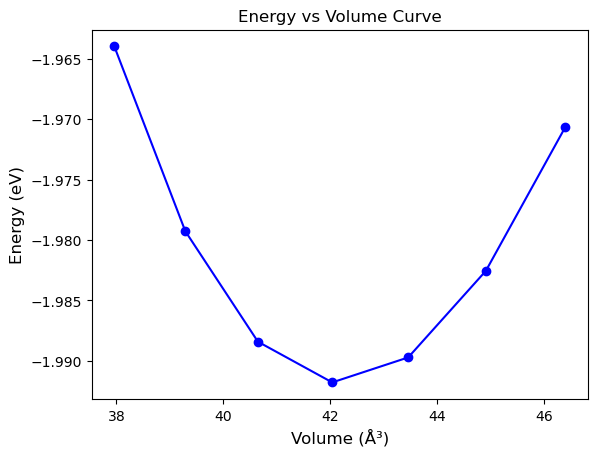

Using cached GRACE model from /home/poul/.cache/grace/GRACE-2L-OAM
Model license: Academic Software License


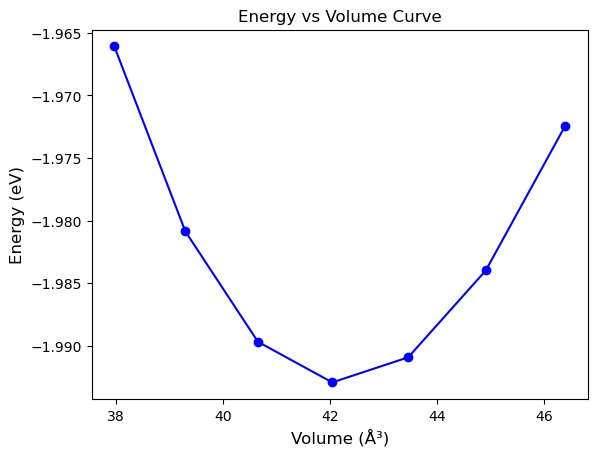

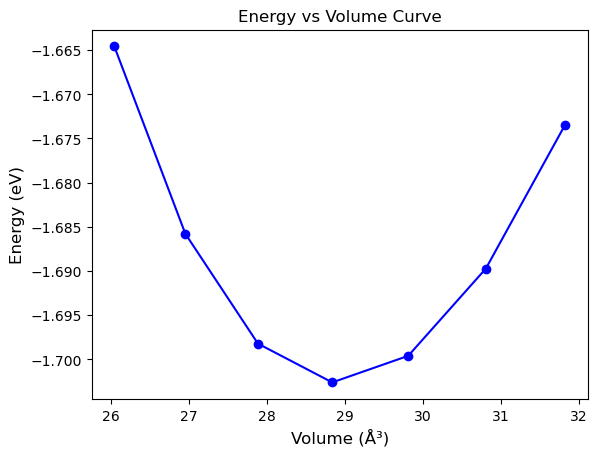

Using cached GRACE model from /home/poul/.cache/grace/GRACE-1L-OAM
Model license: Academic Software License


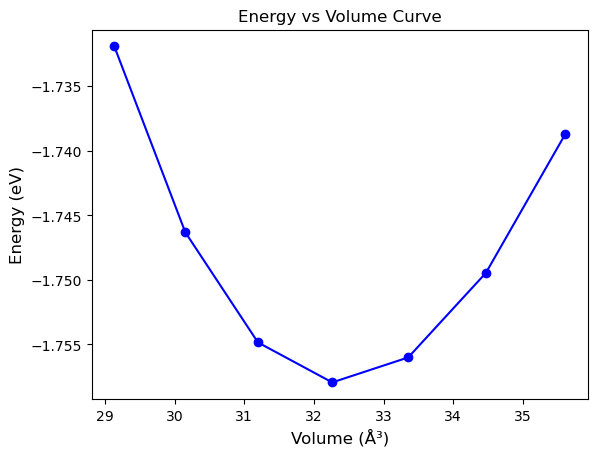

Using cached GRACE model from /home/poul/.cache/grace/GRACE-2L-OAM
Model license: Academic Software License


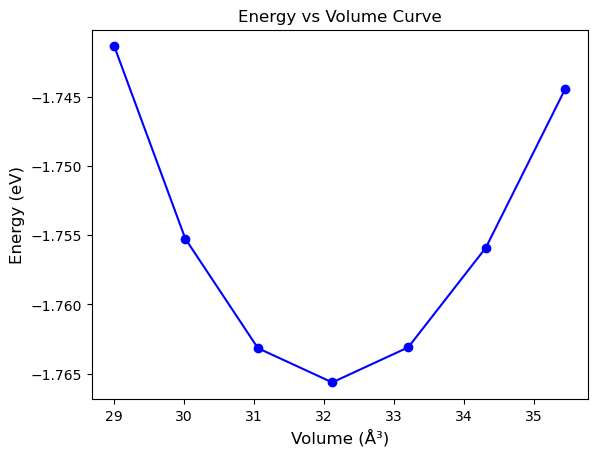

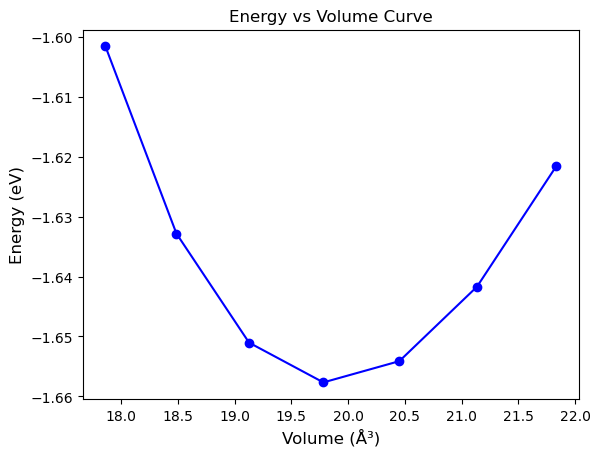

Using cached GRACE model from /home/poul/.cache/grace/GRACE-1L-OAM
Model license: Academic Software License


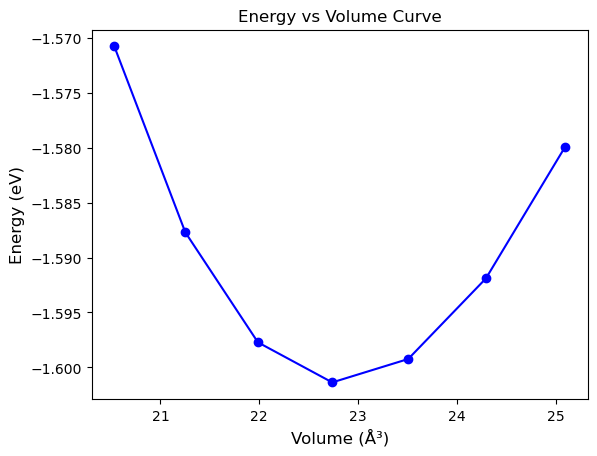

Using cached GRACE model from /home/poul/.cache/grace/GRACE-2L-OAM
Model license: Academic Software License


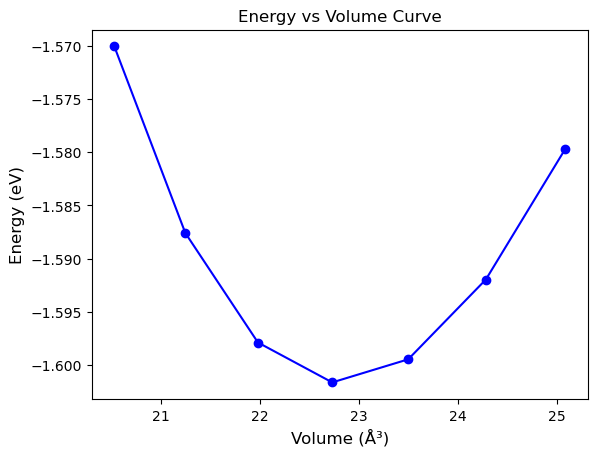

In [16]:
import os
import matplotlib.pyplot as plt


# Structure labels as element-strings: (the actual atomic structures are generated within the workflow)
struc_labels = ["Ca", "CaMg", "Mg",]

# Define potential paths and assign labels (these labels will be part of the workflow name)
potentials = {
    'LinearACE': "potentials/Ca_Mg_linear_potential.yace",
    # "ACE_nfuncs_10": "potentials/Bad_linear_potential.yace",
    # "ACE_nfuncs_50": "potentials/Better_potential.yace",
    # "GRACE_1L_r6": "MP_GRACE_1L_r6_07Nov2024",
    "GRACE_1L_OAM": "GRACE-1L-OAM",
    "GRACE_2L_OAM" : "GRACE-2L-OAM"
}

# Create an empty dictionary to store the workflows:
workflows = {}

# Loop over all structure and potential combinations:
for struc_label in struc_labels:
    for pot_label, pot_path in potentials.items():
        
        # Create a unique workflow name
        wf_name = f"{struc_label}_{pot_label}"
        
        wf = make_murnaghan_workflow(
            workflow_name=wf_name,
            element_str=struc_label,
            potential_path=pot_path,
            delete_existing_savefiles=True
        )
        # Set the structure input (other inputs like fmax, max_steps, etc. can be set here as needed)
        # wf.inputs.structure = structure
        
        # Run the workflow.
        wf.run()
        
        # Save the workflow object for later analysis/plotting.
        workflows[wf_name] = wf

In [17]:
workflows

{'Ca_LinearACE': <pyiron_workflow.workflow.Workflow at 0x7f5500abd210>,
 'Ca_GRACE_1L_OAM': <pyiron_workflow.workflow.Workflow at 0x7f5500adf150>,
 'Ca_GRACE_2L_OAM': <pyiron_workflow.workflow.Workflow at 0x7f547872ed10>,
 'CaMg_LinearACE': <pyiron_workflow.workflow.Workflow at 0x7f54b7c926d0>,
 'CaMg_GRACE_1L_OAM': <pyiron_workflow.workflow.Workflow at 0x7f5478672c10>,
 'CaMg_GRACE_2L_OAM': <pyiron_workflow.workflow.Workflow at 0x7f54b7ca7810>,
 'Mg_LinearACE': <pyiron_workflow.workflow.Workflow at 0x7f540c31f290>,
 'Mg_GRACE_1L_OAM': <pyiron_workflow.workflow.Workflow at 0x7f540c3dad90>,
 'Mg_GRACE_2L_OAM': <pyiron_workflow.workflow.Workflow at 0x7f543060a190>}

In [18]:
# DFT references taken from https://doi.org/10.1103/PhysRevB.107.104103

ref_e0 = {"Ca": -1.930,
          "Mg" : -1.506,
          "CaMg" : -1.802}

ref_V = {"Ca": 42.193,
          "Mg" : 22.953,
          "CaMg" : 30.939}

Ca_LinearACE
Ca_GRACE_1L_OAM
Ca_GRACE_2L_OAM
CaMg_LinearACE
CaMg_GRACE_1L_OAM
CaMg_GRACE_2L_OAM
Mg_LinearACE
Mg_GRACE_1L_OAM
Mg_GRACE_2L_OAM


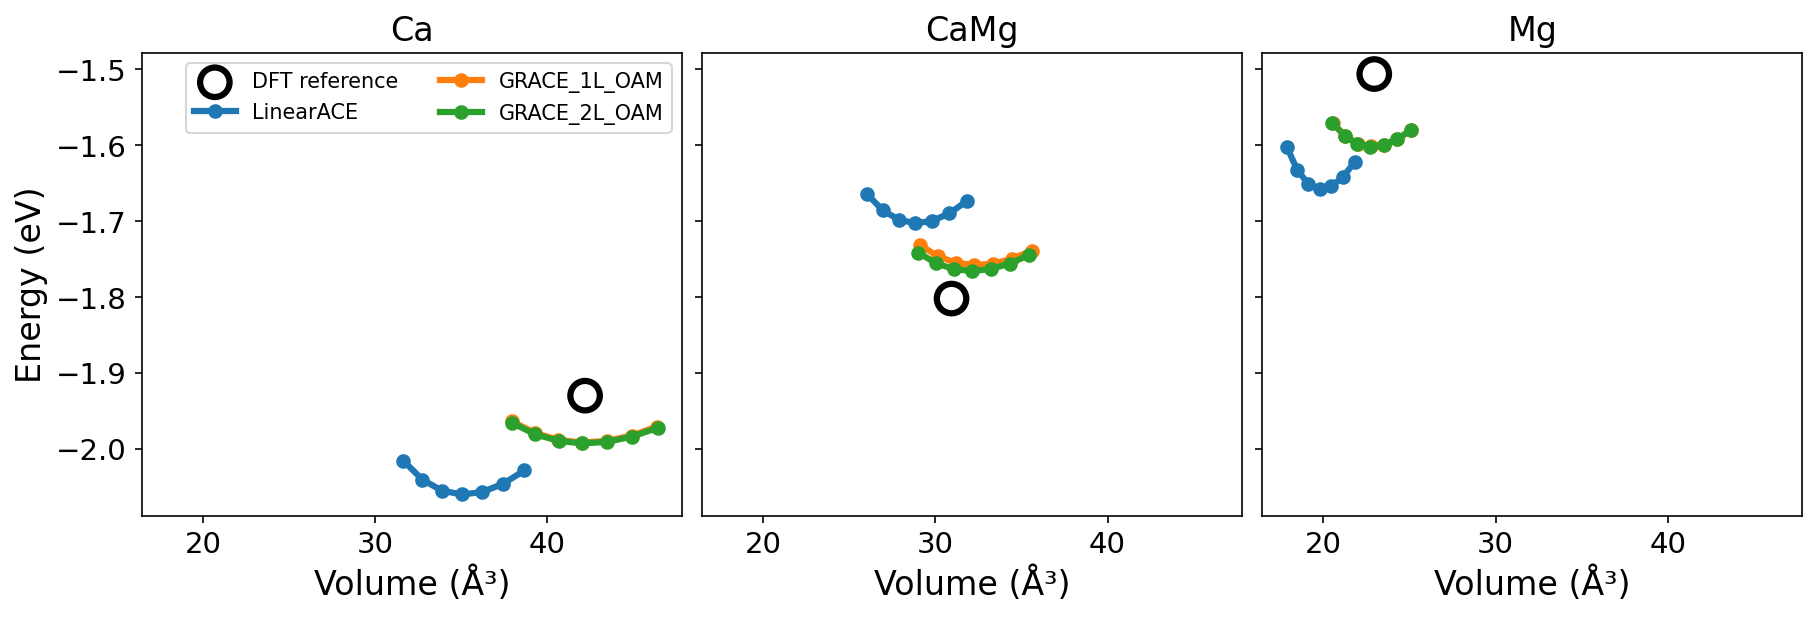

In [19]:
fontsize = 16

fig, ax_list = plt.subplots(ncols=3, dpi=150, sharex=True, sharey=True, figsize=(12,4), constrained_layout=True)

ii = 0
for ii, struc_label in enumerate(struc_labels):
    ax = ax_list[ii]
    ii += 1

    ref_e = ref_e0[struc_label]
    ref_v = ref_V[struc_label]
    # ax.axhline(ref_e, ls="--", label="DFT reference")
    ax.scatter(ref_v,ref_e, 
               marker="o",
               s=200,
               facecolor="None",
               edgecolor="k",
               lw=3,
               zorder=5,
               label="DFT reference"
              )

    
    for jj,pot_label in enumerate(potentials.keys()):
        wf_name = f"{struc_label}_{pot_label}"
        print(wf_name)

        wf = workflows[wf_name]
        df = wf.calculate_ev_curve.outputs.df.value
        
        ax.plot(df['volume'], df['energy'],
                'o-', 
                lw=3,
                label=f"{pot_label}")
        ax.set_xlabel("Volume (Å³)",fontsize=fontsize)
        ax.tick_params(labelsize=fontsize-2)
        ax.set_title(struc_label,fontsize=fontsize)
        


ax_list[0].set_ylabel("Energy (eV)",fontsize=fontsize)
ax_list[0].legend(prop={"size":fontsize-6}, ncol=2)

# plt.tight_layout()
plt.show()

Thus we can neatly compare the different potentials with DFT references. For the above plots, the DFT references are taken from [Poul et. al.](https://doi.org/10.1103/PhysRevB.107.104103) 

In [20]:
# DFT references taken from https://doi.org/10.1103/PhysRevB.107.104103

ref_B0 = {"Ca": 17.500,
          "CaMg" : 25.769,
          "Mg" : 36.434,
          }

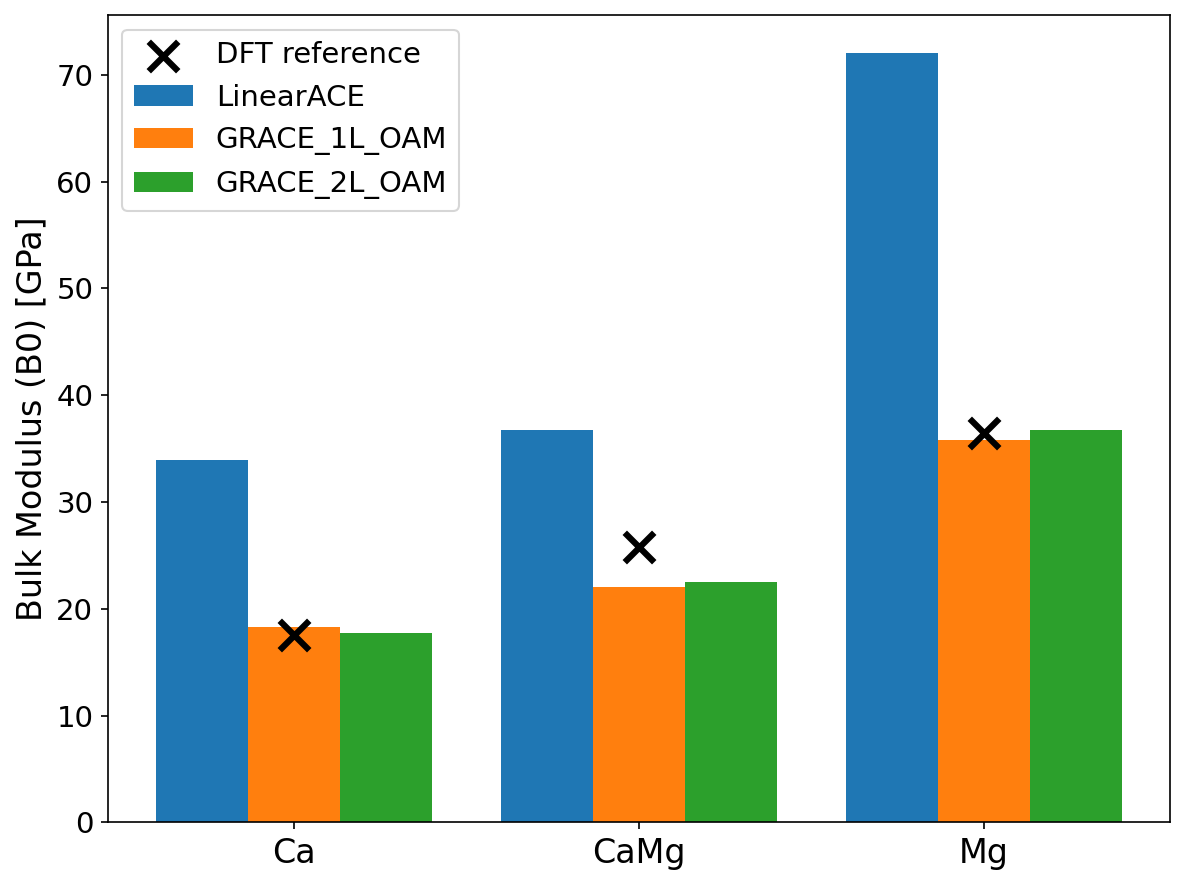

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fontsize = 16

# Define the order of structures and potentials.
structures = list(struc_labels)  
pot_labels = list(potentials.keys())   

B0_values = []  # rows: structures, columns: potentials

for struc_label in structures:
    B0_row = []
    for pot_label in pot_labels:
        wf_name = f"{struc_label}_{pot_label}"
        wf = workflows[wf_name]
        # Assuming your FitBirchMurnaghanEOS node returns a dictionary mapped to 'eos'
        B0 = wf.outputs["fit_eos__B0_GPa"].value
        B0_row.append(B0)
    B0_values.append(B0_row)

B0_values = np.array(B0_values)  # Shape: (n_structures, n_potentials)

# Plotting a grouped bar chart.
fig, ax = plt.subplots(dpi=150, figsize=(8, 6))

n_groups = len(structures)
n_bars = len(pot_labels)
index = np.arange(n_groups)  # positions for groups on the x-

ax.scatter(index, ref_B0.values(),
           marker="x",
           s=200,
           color="k",
           label="DFT reference",
           lw=3,
           zorder=5,
          )

total_group_width = 0.8  
bar_width = total_group_width / n_bars  

for i, pot_label in enumerate(pot_labels):
    # Compute offset so that bars are centered on each group position.
    offset = (i - (n_bars - 1) / 2) * bar_width
    ax.bar(index + offset, B0_values[:, i], bar_width, label=pot_label)

ax.set_ylabel("Bulk Modulus (B0) [GPa]", fontsize=fontsize)
ax.set_xticks(index)
ax.set_xticklabels(structures, fontsize=fontsize)
ax.tick_params(axis="y", labelsize=fontsize-2)
ax.legend(fontsize=fontsize-2)

plt.tight_layout()
plt.show()


DFT references are taken from [Poul et. al.](https://doi.org/10.1103/PhysRevB.107.104103) 